# Lab C2 W3: Transfer Learning

In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-16 05:28:05--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   150MB/s    in 0.6s    

2023-10-16 05:28:06 (150 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# instantiate the pretrained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(include_top=False,
                               input_shape=(150,150,3),
                               weights=None)

pretrained_model.load_weights(local_weights)

# freeze pretrained model
for layer in pretrained_model.layers:
  layer.trainable = False

In [ ]:
# look out the available layer
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
# pick up to the desired layer
last_layer = pretrained_model.get_layer('mixed7')
print(f'Output shape is {last_layer.output_shape}')
last_output = last_layer.output

Output shape is (None, 7, 7, 768)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

# flatten the pretrained layer
x = tf.keras.layers.Flatten()(last_output)
# add dense layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# add dropout layer to regularize the ouput
x = tf.keras.layers.Dropout(0.2)(x)
# add output layer
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(pretrained_model.input, x)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

##### setup dataset

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-10-16 05:28:20--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   107MB/s    in 0.6s    

2023-10-16 05:28:21 (107 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# prepare the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os

zip_local = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zip_local, 'r')
zip_ref.extractall()

training_dir = 'cats_and_dogs_filtered/train'
training_cats_dir = os.path.join(training_dir, 'cats')
training_dogs_dir = os.path.join(training_dir, 'dogs')

validation_dir = 'cats_and_dogs_filtered/validation'
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    training_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150,150)
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    class_mode='binary',
    target_size = (150,150)
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/20
100/100 [==============================] - 37s 237ms/step - loss: 0.3239 - accuracy: 0.8730 - val_loss: 0.1346 - val_accuracy: 0.9440
Epoch 2/20
100/100 [==============================] - 18s 182ms/step - loss: 0.1798 - accuracy: 0.9220 - val_loss: 0.1527 - val_accuracy: 0.9400
Epoch 3/20
100/100 [==============================] - 19s 189ms/step - loss: 0.2078 - accuracy: 0.9115 - val_loss: 0.1111 - val_accuracy: 0.9590
Epoch 4/20
100/100 [==============================] - 16s 162ms/step - loss: 0.1728 - accuracy: 0.9330 - val_loss: 0.1020 - val_accuracy: 0.9630
Epoch 5/20
100/100 [==============================] - 20s 201ms/step - loss: 0.1628 - accuracy: 0.9360 - val_loss: 0.0906 - val_accuracy: 0.9640
Epoch 6/20
100/100 [==============================] - 16s 164ms/step - loss: 0.1580 - accuracy: 0.9380 - val_loss: 0.1342 - val_accuracy: 0.9530
Epoch 7/20
100/100 [==============================] - 17s 174ms/step - loss: 0.1559 - accuracy: 0.9365 - val_loss: 0.0953 - val_ac

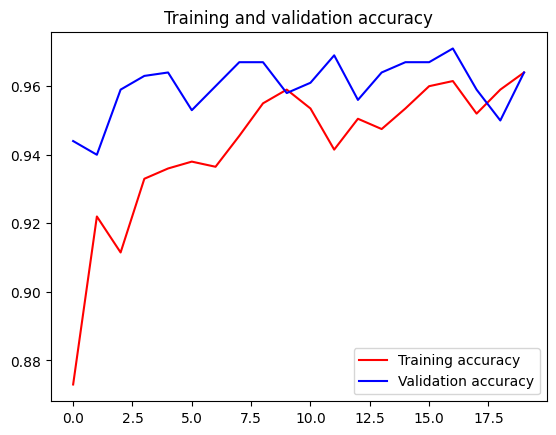

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat-1192026_640.jpg to cat-1192026_640.jpg
Saving cat-1455468_640.jpg to cat-1455468_640.jpg
Saving cat-1647775_640.jpg to cat-1647775_640.jpg
Saving cat-2083492_640.jpg to cat-2083492_640.jpg
Saving cropped_cat-2083492_640.jpg to cropped_cat-2083492_640.jpg
Saving cropped_dog-4988985_640.jpg to cropped_dog-4988985_640.jpg
Saving dog-1850465_640.jpg to dog-1850465_640.jpg
Saving dog-3071334_640.jpg to dog-3071334_640.jpg
Saving dog-3389729_640.jpg to dog-3389729_640.jpg
Saving dog-4988985_640.jpg to dog-4988985_640.jpg
Saving puppy-1903313_640.jpg to puppy-1903313_640.jpg
1/1 [==============================] - 2s 2s/step
[1.03054044e-10]
cat-1192026_640.jpg is a cat
1/1 [==============================] - 0s 36ms/step
[1.0351565e-09]
cat-1455468_640.jpg is a cat
1/1 [==============================] - 0s 40ms/step
[0.85506207]
cat-1647775_640.jpg is a dog
1/1 [==============================] - 0s 37ms/step
[0.01524474]
cat-2083492_640.jpg is a cat
1/1 [============================

# C2W3 Assignment

## Prepare Data

In [ ]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

In [ ]:
import zipfile

zip_local = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(zip_local, 'r')
zip_ref.extractall('/horse-or-human')

zip_local = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(zip_local, 'r')
zip_ref.extractall('/validation-horse-or-human')

In [ ]:
import os

train_dir = '/horse-or-human'
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')

validation_dir = '/validation-horse-or-human'
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(150,150),
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=32,
    target_size=(150,150),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Prepare Model

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-16 05:36:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   170MB/s    in 0.5s    

2023-10-16 05:36:06 (170 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weight = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weight)

for layer in pre_trained_model.layers:
  layer.trainable=False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

from above, we can see that all pretrained layers are frozen

In [ ]:
last_desired_layer = pre_trained_model.get_layer('mixed7')
print(f'shape of las output {last_desired_layer.output_shape}')
last_output = last_desired_layer.output

shape of las output (None, 7, 7, 768)


In [ ]:
print(f'Type of pre trained model is {type(pre_trained_model)}')

Type of pre trained model is <class 'keras.src.engine.functional.Functional'>


#### The type pf preatrained model is functional so we continue add on tof the layer using functional API like below

In [ ]:
# create model
from tensorflow.keras import Model
from tensorflow.keras import layers

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [ ]:
# grader-required-cell

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
callback=myCallback()

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

model.fit(train_generator,
          epochs=100,
          validation_data=validation_generator,
          verbose=2,
          callbacks=callback)

Epoch 1/100
33/33 - 18s - loss: 0.2182 - accuracy: 0.9289 - val_loss: 0.0346 - val_accuracy: 0.9883 - 18s/epoch - 543ms/step
Epoch 2/100
33/33 - 12s - loss: 0.0232 - accuracy: 0.9903 - val_loss: 0.0257 - val_accuracy: 0.9922 - 12s/epoch - 352ms/step
Epoch 3/100
33/33 - 12s - loss: 0.0355 - accuracy: 0.9873 - val_loss: 0.0200 - val_accuracy: 0.9883 - 12s/epoch - 367ms/step
Epoch 4/100
33/33 - 12s - loss: 0.0244 - accuracy: 0.9912 - val_loss: 0.0158 - val_accuracy: 0.9961 - 12s/epoch - 372ms/step
Epoch 5/100
33/33 - 12s - loss: 0.0160 - accuracy: 0.9942 - val_loss: 0.0035 - val_accuracy: 1.0000 - 12s/epoch - 364ms/step
Epoch 6/100
33/33 - 12s - loss: 0.0164 - accuracy: 0.9912 - val_loss: 0.0074 - val_accuracy: 0.9961 - 12s/epoch - 365ms/step
Epoch 7/100

Reached 99.9% accuracy so cancelling training!
33/33 - 12s - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0315 - val_accuracy: 0.9844 - 12s/epoch - 378ms/step


In [ ]:
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


##### so many pramaters used eventhough image was reduced from 300x300 to 150,150. So, be wise in set up the appropriate parameter

In [ ]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

# urut berdasarkan abjad
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving animal-4071342_640.jpg to animal-4071342_640 (2).jpg
Saving arabian-horse-4270748_640.jpg to arabian-horse-4270748_640 (2).jpg
Saving girl2.jpg to girl2 (2).jpg
Saving girl-510451_640.jpg to girl-510451_640 (2).jpg
Saving horse-3611921_640.jpg to horse-3611921_640 (2).jpg
Saving mountain-5092625_640.jpg to mountain-5092625_640 (2).jpg
Saving white-horse-3010129_1280.jpg to white-horse-3010129_1280 (2).jpg
Saving woman-4820889_640.jpg to woman-4820889_640 (2).jpg
Saving woman-4906077_640.jpg to woman-4906077_640 (2).jpg
1/1 [==============================] - 0s 26ms/step
[3.1260083e-08]
animal-4071342_640 (2).jpg is a horse
1/1 [==============================] - 0s 23ms/step
[1.30660105e-08]
arabian-horse-4270748_640 (2).jpg is a horse
1/1 [==============================] - 0s 24ms/step
[0.9999603]
girl2 (2).jpg is a human
1/1 [==============================] - 0s 26ms/step
[0.99846894]
girl-510451_640 (2).jpg is a human
1/1 [==============================] - 0s 26ms/step
[5.5994

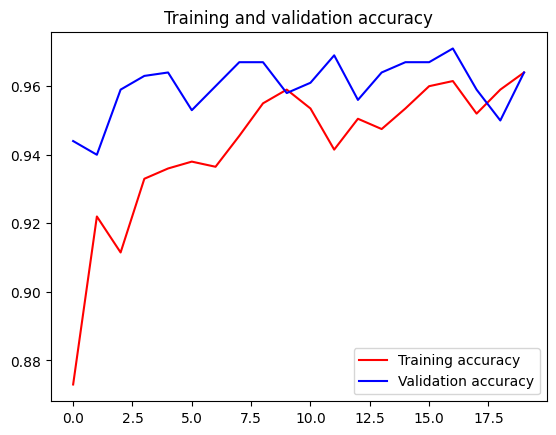

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

## Transfer learning is great for both Cats-dogs dataset and Horses-Humans dataset